# Compare Different Models for Time Series Forecasting


# Introduction

In this project, we will see how RNN, CNN and LSTM models perform for Time Series Forecasting.


Import the libraries

In [42]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
import pandas as pd
from datetime import datetime
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, LSTM, Activation, Dropout
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

# Section 1: Simple RNN

In this section, we will build a recurrent neural network and train it to forecast a single time series.

#### Setting Up The Data

Read the weather data from Kaggle

In [43]:
df = pd.read_csv('C:/Users/taihs/OneDrive/Documents/SGunited Data Analyst/weatherHistory.csv')
df.head(10)

,Formatted Date,Summary,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars),Daily Summary
0,1/4/2006 6:00,Partly Cloudy,rain,9.472222,7.388889,0.89,14.1197,251,15.8263,0,1015.13,Partly cloudy throughout the day.
1,1/4/2006 7:00,Partly Cloudy,rain,9.355556,7.227778,0.86,14.2646,259,15.8263,0,1015.63,Partly cloudy throughout the day.
2,1/4/2006 8:00,Mostly Cloudy,rain,9.377778,9.377778,0.89,3.9284,204,14.9569,0,1015.94,Partly cloudy throughout the day.
3,1/4/2006 9:00,Partly Cloudy,rain,8.288889,5.944444,0.83,14.1036,269,15.8263,0,1016.41,Partly cloudy throughout the day.
4,1/4/2006 10:00,Mostly Cloudy,rain,8.755556,6.977778,0.83,11.0446,259,15.8263,0,1016.51,Partly cloudy throughout the day.
5,1/4/2006 11:00,Partly Cloudy,rain,9.222222,7.111111,0.85,13.9587,258,14.9569,0,1016.66,Partly cloudy throughout the day.
6,1/4/2006 12:00,Partly Cloudy,rain,7.733333,5.522222,0.95,12.3648,259,9.9820,0,1016.72,Partly cloudy throughout the day.
7,1/4/2006 13:00,Partly Cloudy,rain,8.772222,6.527778,0.89,14.1519,260,9.9820,0,1016.84,Partly cloudy throughout the day.
8,1/4/2006 14:00,Partly Cloudy,rain,10.822222,10.822222,0.82,11.3183,259,9.9820,0,1017.37,Partly cloudy throughout the day.
9,1/4/2006 15:00,Partly Cloudy,rain,13.772222,13.772222,0.72,12.5258,279,9.9820,0,1017.22,Partly cloudy throughout the day.


We will select the Temperature (C) column for training and forecast.

In [44]:
df.dtypes

Formatted Date               object
Summary                      object
Precip Type                  object
Temperature (C)             float64
Apparent Temperature (C)    float64
Humidity                    float64
Wind Speed (km/h)           float64
Wind Bearing (degrees)        int64
Visibility (km)             float64
Loud Cover                    int64
Pressure (millibars)        float64
Daily Summary                object
dtype: object

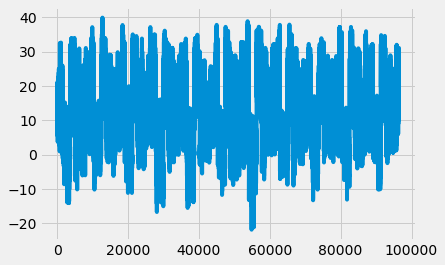

In [45]:
plt.plot(df["Temperature (C)"])

Convert from string to datetime format for 'Formatted Date' column

In [46]:
df['Formatted Date'] = pd.to_datetime(df['Formatted Date'],format='%d/%m/%Y %H:%M')
df.set_index(df['Formatted Date'],inplace=True)
df.dtypes
df.drop('Formatted Date',axis=1,inplace=True)

<AxesSubplot:xlabel='Formatted Date'>

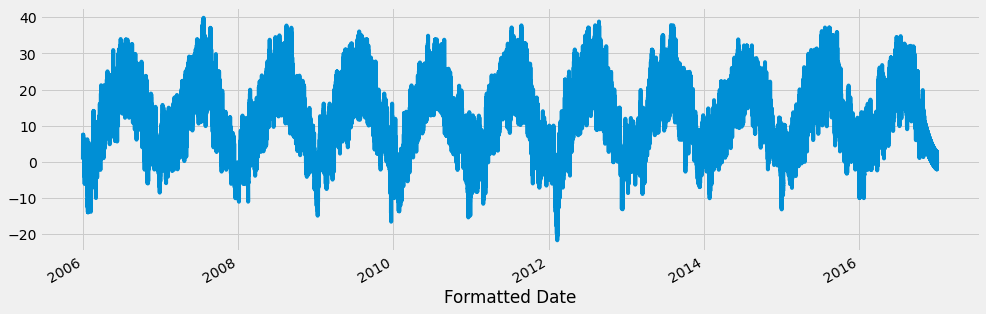

In [47]:
#quick plot of full time series
plt.figure(figsize = (15,5))
df['Temperature (C)'].plot()

In [48]:
df['Temperature (C)']
df.head()

,Summary,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars),Daily Summary
Formatted Date,,,,,,,,,,,
2006-04-01 06:00:00,Partly Cloudy,rain,9.472222,7.388889,0.89,14.1197,251,15.8263,0,1015.13,Partly cloudy throughout the day.
2006-04-01 07:00:00,Partly Cloudy,rain,9.355556,7.227778,0.86,14.2646,259,15.8263,0,1015.63,Partly cloudy throughout the day.
2006-04-01 08:00:00,Mostly Cloudy,rain,9.377778,9.377778,0.89,3.9284,204,14.9569,0,1015.94,Partly cloudy throughout the day.
2006-04-01 09:00:00,Partly Cloudy,rain,8.288889,5.944444,0.83,14.1036,269,15.8263,0,1016.41,Partly cloudy throughout the day.
2006-04-01 10:00:00,Mostly Cloudy,rain,8.755556,6.977778,0.83,11.0446,259,15.8263,0,1016.51,Partly cloudy throughout the day.


Define two utility functions that let us extract and plot the last $n$ days of data (remember that this is an hourly time series, so each day has 24 time steps).   

In [49]:
def get_n_last_days(df, series_name, n_days):
    """
    Extract last n_days of an hourly time series
    """
    
    return df[series_name][-(24*n_days):] 

def plot_n_last_days(df, series_name, n_days):
    """
    Plot last n_days of an hourly time series 
    """
    plt.figure(figsize = (10,5))   
    plt.plot(get_n_last_days(df, series_name, n_days), 'k-')
    plt.title('{0} Air Quality Time Series - {1} days'
              .format(series_name, n_days))
    plt.xlabel('Recorded Hour')
    plt.ylabel('Reading')
    plt.grid(alpha=0.3)

What do the last 30 days of data look like?

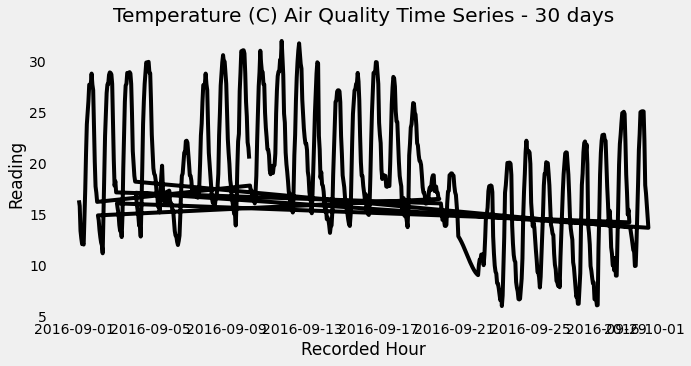

In [50]:
plot_n_last_days(df, 'Temperature (C)', 30)

There appears to be a seasonal component.

Define utility functions that allow us to extract the formatted data. The **get_train_test_data** function gives us the flexibility to define the length of the extracted training and test sequences and the number of time steps to use for prediction -- we'll run simple tests of our models by holding out the end of the extracted sequence and generating predictions to compare against the ground truth.

Since our model will perform better with multiple training samples, we draw many slices from the entire training sequence, starting at different points in time. The gap between starting points of these slices is controlled by the **sample_gap** parameter.

In [51]:
df.shape

(96453, 11)

In [52]:
def get_keras_format_series(series):
    """
    Convert a series to a numpy array of shape 
    [n_samples, time_steps, features]
    """
    
    series = np.array(series)
    return series.reshape(series.shape[0], series.shape[1], 1)

def get_train_test_data(df, series_name, series_days, input_hours, 
                        test_hours, sample_gap=3):
    """
    Utility processing function that splits an hourly time series into 
    train and test with keras-friendly format, according to user-specified
    choice of shape.    
    
    arguments
    ---------
    df (dataframe): dataframe with time series columns
    series_name (string): column name in df
    series_days (int): total days to extract
    input_hours (int): length of sequence input to network 
    test_hours (int): length of held-out terminal sequence
    sample_gap (int): step size between start of train sequences; default 5
    
    returns
    ---------
    tuple: train_X, test_X_init, train_y, test_y     
    """
    
    forecast_series = get_n_last_days(df, series_name, series_days).values # reducing our forecast series to last n days

    train = forecast_series[:-test_hours] # training data is remaining days until amount of test_hours
    test = forecast_series[-test_hours:] # test data is the remaining test_hours

    train_X, train_y = [], []

    # range 0 through # of train samples - input_hours by sample_gap. 
    # This is to create many samples with corresponding
    for i in range(0, train.shape[0]-input_hours, sample_gap): 
        train_X.append(train[i:i+input_hours]) # each training sample is of length input hours
        train_y.append(train[i+input_hours]) # each y is just the next step after training sample

    train_X = get_keras_format_series(train_X) # format our new training set to keras format
    train_y = np.array(train_y) # make sure y is an array to work properly with keras
    
    # The set that we had held out for testing (must be same length as original train input)
    test_X_init = test[:input_hours] 
    test_y = test[input_hours:] # test_y is remaining values from test set
    
    return train_X, test_X_init, train_y, test_y

Get the training and testing data

In [64]:
series_days = 800
input_hours = 12
test_hours = 72

train_X, test_X_init, train_y, test_y = \
    (get_train_test_data(df, 'Temperature (C)', series_days, 
                         input_hours, test_hours))

In [65]:
print('Training input shape: {}'.format(train_X.shape))
print('Training output shape: {}'.format(train_y.shape))
print('Test input shape: {}'.format(test_X_init.shape))
print('Test output shape: {}'.format(test_y.shape))

Training input shape: (6372, 12, 1)
Training output shape: (6372,)
Test input shape: (12,)
Test output shape: (60,)


Define a reusable function for training a simple RNN model using keras.

In [66]:
def fit_SimpleRNN(train_X, train_y, cell_units, epochs):
    """
    Fit Simple RNN to data train_X, train_y 
    
    arguments
    ---------
    train_X (array): input sequence samples for training 
    train_y (list): next step in sequence targets
    cell_units (int): number of hidden units for RNN cells  
    epochs (int): number of training epochs   
    """

    # initialize model
    model = Sequential() 
    
    # construct an RNN layer with specified number of hidden units
    # per cell and desired sequence input format 
    model.add(SimpleRNN(cell_units, input_shape=(train_X.shape[1],1)))
    
    # add an output layer to make final predictions 
    model.add(Dense(1))
    
    # define the loss function / optimization strategy, and fit
    # the model with the desired number of passes over the data (epochs) 
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(train_X, train_y, epochs=epochs, batch_size=64, verbose=0)
    
    return model

Define a prediction method and a utility function for plotting its output against the ground truth.

In [67]:
def predict(X_init, n_steps, model):
    """
    Given an input series matching the model's expected format,
    generates model's predictions for next n_steps in the series      
    """
    
    X_init = X_init.copy().reshape(1,-1,1)
    preds = []
    
    # iteratively take current input sequence, generate next step pred,
    # and shift input sequence forward by a step (to end with latest pred).
    # collect preds as we go.
    for _ in range(n_steps):
        pred = model.predict(X_init)
        preds.append(pred)
        X_init[:,:-1,:] = X_init[:,1:,:] # replace first 11 values with 2nd through 12th
        X_init[:,-1,:] = pred # replace 12th value with prediction
    
    preds = np.array(preds).reshape(-1,1)
    
    return preds

def predict_and_plot(X_init, y, model, title):
    """
    Given an input series matching the model's expected format,
    generates model's predictions for next n_steps in the series,
    and plots these predictions against the ground truth for those steps 
    
    arguments
    ---------
    X_init (array): initial sequence, must match model's input shape
    y (array): true sequence values to predict, follow X_init
    model (keras.models.Sequential): trained neural network
    title (string): plot title   
    """
    
    y_preds = predict(test_X_init, n_steps=len(y), model=model) # predict through length of y
    # Below ranges are to set x-axes
    start_range = range(1, test_X_init.shape[0]+1) #starting at one through to length of test_X_init to plot X_init
    predict_range = range(test_X_init.shape[0], test_hours)  #predict range is going to be from end of X_init to length of test_hours
    
    #using our ranges we plot X_init
    plt.plot(start_range, test_X_init)
    #and test and actual preds
    plt.plot(predict_range, test_y, color='orange')
    plt.plot(predict_range, y_preds, color='teal', linestyle='--')
    
    plt.title(title)
    plt.legend(['Initial Series','Target Series','Predictions'])

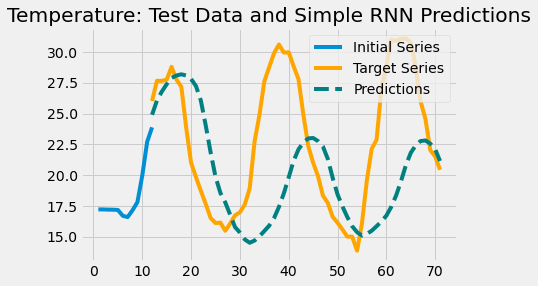

In [68]:
model = fit_SimpleRNN(train_X, train_y, cell_units=70, epochs=300)
predict_and_plot(test_X_init, test_y, model,
                 'Temperature: Test Data and Simple RNN Predictions')

In [69]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_4 (SimpleRNN)     (None, 70)                5040      
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 71        
Total params: 5,111
Trainable params: 5,111
Non-trainable params: 0
_________________________________________________________________


# Section 2: LSTM

In this section, we'll build on our previous work by introducing LSTM models as an enhancement to the RNNs we've trained so far.

In [70]:
def fit_LSTM(train_X, train_y, cell_units, epochs):
    """
    Fit LSTM to data train_X, train_y 
    
    arguments
    ---------
    train_X (array): input sequence samples for training 
    train_y (list): next step in sequence targets
    cell_units (int): number of hidden units for LSTM cells  
    epochs (int): number of training epochs   
    """
    
    # initialize model
    model = Sequential() 
    
    # construct a LSTM layer with specified number of hidden units
    # per cell and desired sequence input format 
    model.add(LSTM(cell_units, input_shape=(train_X.shape[1],1))) #,return_sequences= True))
    #model.add(LSTM(cell_units_l2, input_shape=(train_X.shape[1],1)))
    
    # add an output layer to make final predictions 
    model.add(Dense(1))
    
    # define the loss function / optimization strategy, and fit
    # the model with the desired number of passes over the data (epochs) 
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(train_X, train_y, epochs=epochs, batch_size=64, verbose=0)
    
    return model

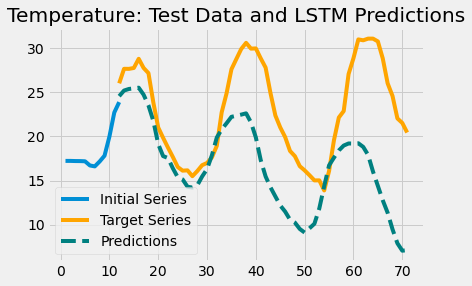

In [71]:
model = fit_LSTM(train_X, train_y, cell_units=70, epochs=300) 

predict_and_plot(test_X_init, test_y, model, 
                 'Temperature: Test Data and LSTM Predictions')

In [61]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 70)                20160     
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 71        
Total params: 20,231
Trainable params: 20,231
Non-trainable params: 0
_________________________________________________________________


# Section 3: CNN

In this section, we'll introduce CNN model.

In [62]:
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers import Dense, LSTM, RepeatVector, TimeDistributed, Flatten

def fit_CNN(train_X, train_y, cell_units, epochs):
    """
    Fit Simple RNN to data train_X, train_y 
    
    arguments
    ---------
    train_X (array): input sequence samples for training 
    train_y (list): next step in sequence targets
    cell_units (int): number of hidden units for RNN cells  
    epochs (int): number of training epochs   
    """

    # initialize model
    model = Sequential() 
    
    # construct an CNN layer with specified number of hidden units
    # per cell and desired sequence input format 
    model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(train_X.shape[1],1)))
    model.add(Flatten())
    model.add(Dense(50, activation='relu'))
    # add an output layer to make final predictions 
    model.add(Dense(1))
    
    # define the loss function / optimization strategy, and fit
    # the model with the desired number of passes over the data (epochs) 
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(train_X, train_y, epochs=epochs, batch_size=64, verbose=0)
    
    return model

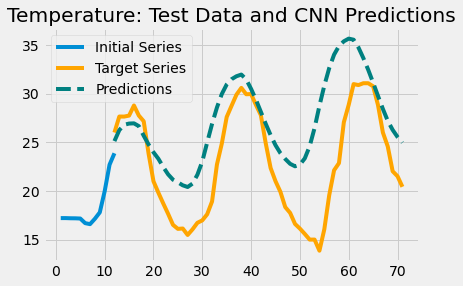

In [72]:
model = fit_CNN(train_X, train_y, cell_units=70, epochs=300) 

predict_and_plot(test_X_init, test_y, model, 
                 'Temperature: Test Data and CNN Predictions')

# Summary

We have looked at the different models RNN, CNN and LSTM for time series forecasting.

We can see RNN performed much better than LSTM and CNN achieved the worst results based on the visuals.

I believe we can achieve better results by training with more data and changing the hyperparameters of the models.